# Tutorial Notebook

Based off MNIST VAE example from PyTorch https://github.com/pytorch/examples/tree/master/vae

Data used: Sinus Endoscopy Video from https://www.youtube.com/watch?v=6niL7Poc_qQ

Simplifying Decisions:

* Downscaling images to 28x28 so can train on personal machine
* Using greyscale image


# Imports

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from skimage import io
from skimage.transform import rescale, resize

# from src import endoscopy_dataset as eds

In [64]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [65]:
# Hyper-parameters
# image_size = 720 * 920
image_size = 28*28
h_dim = 400
z_dim = 20
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

In [66]:
dataset = torchvision.datasets.ImageFolder('data/surgical_video_frames/',
                                           transform=transforms.Compose([
                                                        transforms.Resize((28,28)),
                                                        transforms.ToTensor(),
                                           ]))

data_loader = DataLoader(dataset=dataset,
                         batch_size=batch_size, 
                         shuffle=False)

In [67]:
# Plot the image here using matplotlib.
def plot_image(tensor):
    plt.figure()
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()

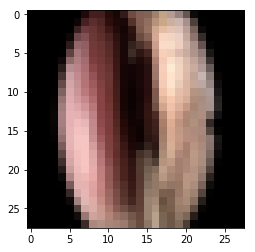

In [68]:
plot_image(dataset[50][0])

In [69]:
class VAE(nn.Module):
    def __init__(self, image_size=image_size, h_dim=h_dim, z_dim=z_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var


In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    
        with torch.no_grad():
            # Save the sampled images
            z = torch.randn(batch_size, z_dim).to(device)
            out = model.decode(z).view(-1, 1, 28, 28)
            save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

            # Save the reconstructed images
            out, _, _ = model(x)
            x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
            save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

/home/davidli/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/15], Step [10/13], Reconst Loss: 167976.7344, KL Div: 7480.9780
Epoch[2/15], Step [10/13], Reconst Loss: 146095.3750, KL Div: 1159.6862
Epoch[3/15], Step [10/13], Reconst Loss: 143577.9844, KL Div: 1047.9801
Epoch[4/15], Step [10/13], Reconst Loss: 144157.9688, KL Div: 1731.9285
Epoch[5/15], Step [10/13], Reconst Loss: 138030.0000, KL Div: 500.2059
Epoch[6/15], Step [10/13], Reconst Loss: 134458.2344, KL Div: 737.2778
Epoch[7/15], Step [10/13], Reconst Loss: 127429.2578, KL Div: 3524.3740
Epoch[8/15], Step [10/13], Reconst Loss: 124559.5625, KL Div: 3964.4062
Epoch[9/15], Step [10/13], Reconst Loss: 123176.7812, KL Div: 2021.1929
Epoch[10/15], Step [10/13], Reconst Loss: 123531.0391, KL Div: 1650.9971
Epoch[11/15], Step [10/13], Reconst Loss: 123247.1719, KL Div: 2768.7888
Epoch[12/15], Step [10/13], Reconst Loss: 122140.7891, KL Div: 2475.5862
Epoch[13/15], Step [10/13], Reconst Loss: 122420.3828, KL Div: 1615.9196
Epoch[14/15], Step [10/13], Reconst Loss: 121359.1484, KL Div: